### Arima + Splitting into micro-models approach

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [32]:
# Load CSV files
csv1 = pd.read_csv("Adjusted_Ad_Campaign_Performance_Data.csv")  # Replace with actual file path
csv2 = pd.read_csv("Banking_KPI_Data.csv")

# Convert 'Time' to datetime for merging
csv1['Time'] = pd.to_datetime(csv1['Time'], format='%b-%y')
print(csv1.columns)
csv2['Time'] = pd.to_datetime(csv2['Time'], format='%b-%y')
print(csv2.columns)

#rename Total Base Mn to Revenue
csv2.rename(columns={'Total Base Mn': 'Revenue'}, inplace=True)

#print all age group
print(csv1['Age group'].unique()) #6
#print all channel name
print(csv1['Channel Name'].unique()) #10

Index(['Time', 'Campaign ID', 'Age group', 'Channel Name', 'Spending',
       'Number of Views', 'Number of Leads'],
      dtype='object')
Index(['Time', 'Number of New Accounts', 'Total Base Mn'], dtype='object')
['18-24' '35-44' '65 and above' '25-34' '55-64' '45-54']
['Influencer' 'Sponsored search ads' 'TikTok ads' 'Instagram Ads' 'Email'
 'LinkedIn' 'Radio ads' 'TV ads' 'Google banner ads' 'Newspaper ads'
 'Facebook ads']


In [91]:

pivot_df = csv1.pivot_table(index='Time', columns='Channel Name', values='Spending', aggfunc='sum', fill_value=0)

#merge pivot_df with csv2 on Time
pivot_df = pivot_df.merge(csv2, on='Time', how='left')
pivot_df.head()


,Time,Email,Facebook ads,Google banner ads,Influencer,Instagram Ads,LinkedIn,Newspaper ads,Radio ads,Sponsored search ads,TV ads,TikTok ads,Number of New Accounts,Revenue
0,2015-01-01,6.07,1.75,10.41,11.27,1.62,1.37,1.00,7.80,9.53,8.67,13.00,24521.10,15045.61
1,2015-02-01,6.49,5.93,11.04,12.03,0.08,10.11,7.40,3.81,4.65,4.23,6.35,24993.12,13417.61
2,2015-03-01,3.48,3.49,5.76,6.47,6.23,7.37,5.49,2.80,8.24,9.35,13.09,22538.59,10509.22
3,2015-04-01,1.90,3.26,3.44,8.94,11.00,9.30,2.28,7.13,8.71,2.83,12.66,30142.71,539.89
4,2015-05-01,4.57,9.38,8.04,8.74,4.72,3.76,5.19,3.07,7.38,6.50,9.75,23178.55,13009.98


In [ ]:
#filter the data for a given age group, channel name
for age_group in csv1['Age group'].unique():
    for channel_name in csv1['Channel Name'].unique():
        csv1_filtered = csv1[csv1['Age group'] == age_group]
        csv1_filtered = csv1_filtered[csv1_filtered['Channel Name'] == channel_name]
        print(age_group, channel_name, len(csv1_filtered)) #roughly 200 rows of data for each age_group and channel_name

#no. combinations = 6 * 10 = 60

In [86]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_merged = pivot_df

# ARIMAX approach (ARIMA with external regressors)
df_merged['Time'] = pd.to_datetime(df_merged['Time'], format='%b-%y')  # Convert to datetime

# Convert all numeric columns to float type
X_arimax = df_merged.drop(columns=['Time', 'Revenue']).astype(float)  # Ensure numeric type
y_arimax = df_merged['Revenue'].astype(float)  # Ensure numeric type
print("Training columns:", X_arimax.columns) #13
# Add trend component
df_merged['trend'] = np.arange(len(df_merged))
X_arimax['trend'] = df_merged['trend']

arimax_model = SARIMAX(
    y_arimax,
    exog=X_arimax,
    
    order=(0, 2, 2),  # Changed to include differencing,, # Order: (0, 2, 2)
    seasonal_order=(0, 1, 1, 12), # Seasonal Order: (0, 1, 1, 12)

    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_results = arimax_model.fit(disp=False)  # Added disp=False to reduce output

print("\nARIMAX Model Summary:")
print(arimax_results.summary())



    


Training columns: Index(['Email', 'Facebook ads', 'Google banner ads', 'Influencer',
       'Instagram Ads', 'LinkedIn', 'Newspaper ads', 'Radio ads',
       'Sponsored search ads', 'TV ads', 'TikTok ads', 'trend'],
      dtype='object')

ARIMAX Model Summary:
                                      SARIMAX Results                                       
Dep. Variable:                              Revenue   No. Observations:                  108
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -737.990
Date:                              Mon, 03 Mar 2025   AIC                           1507.981
Time:                                      12:50:58   BIC                           1545.892
Sample:                                           0   HQIC                          1523.169
                                              - 108                                         
Covariance Type:                                opg                                     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Finding most ideal params for the ARIMAX model

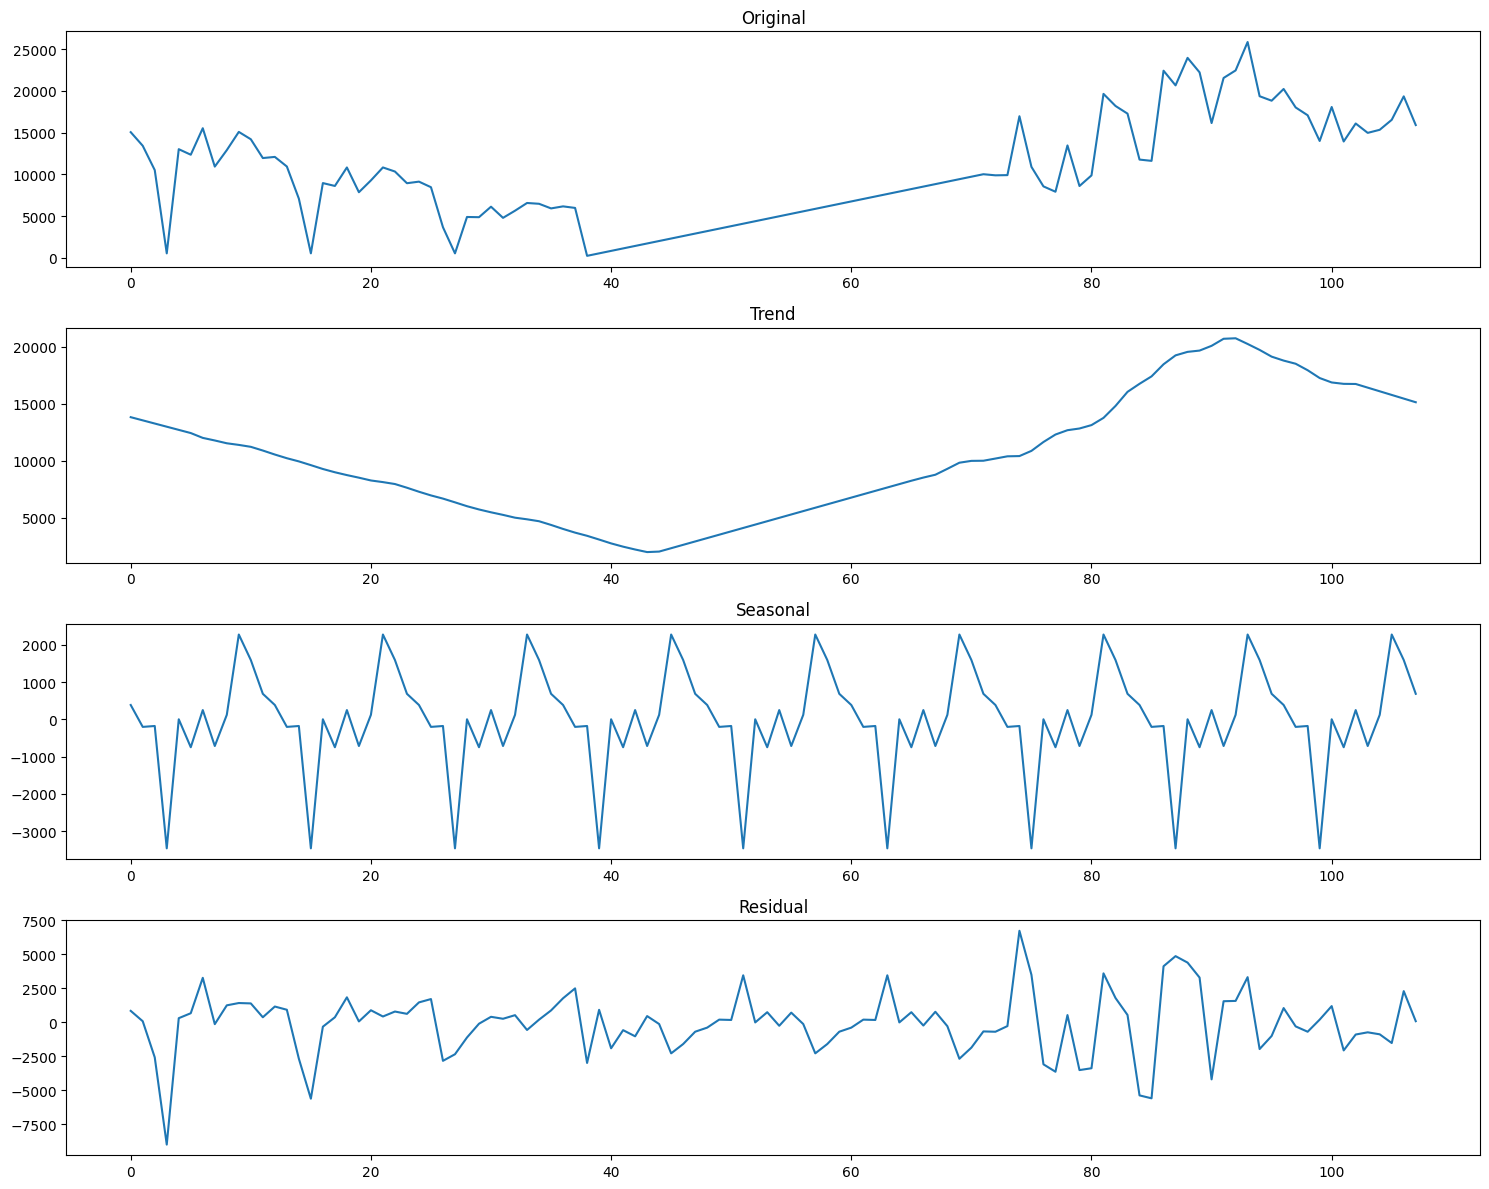

Starting grid search...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa


Best model parameters:
Order: (0, 2, 2)
Seasonal Order: (0, 1, 1, 12)
AIC: 1507.9806896873165

Best Model Summary:
                                      SARIMAX Results                                       
Dep. Variable:                              Revenue   No. Observations:                  108
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -737.990
Date:                              Mon, 03 Mar 2025   AIC                           1507.981
Time:                                      12:47:37   BIC                           1545.892
Sample:                                           0   HQIC                          1523.169
                                              - 108                                         
Covariance Type:                                opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

In [83]:
def evaluate_arimax(params, X, y):
    """
    Evaluate ARIMAX model with given parameters using AIC
    Returns AIC and the fitted model, or (float('inf'), None) if model fails to converge
    """
    order, seasonal_order = params
    try:
        model = SARIMAX(
            y,
            exog=X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        return results.aic, results
    except:
        return float('inf'), None

# Define parameter grids
p = d = q = range(0, 3)  # for non-seasonal components
P = D = Q = range(0, 2)  # for seasonal components
s = [0, 3, 6, 12]  # seasonal period (12 for monthly data)

# First, let's check for seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose the time series
decomposition = seasonal_decompose(y_arimax, period=12, extrapolate_trend='freq')

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Original')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

# Create parameter combinations and perform grid search as before
params_list = []
for p_val in p:
    for d_val in d:
        for q_val in q:
            order = (p_val, d_val, q_val)
            # Non-seasonal model
            params_list.append((order, (0, 0, 0, 0)))
            # Seasonal models
            for P_val in P:
                for D_val in D:
                    for Q_val in Q:
                        for s_val in s:
                            if s_val != 0:  # Skip if s=0 as it's already covered in non-seasonal
                                seasonal_order = (P_val, D_val, Q_val, s_val)
                                params_list.append((order, seasonal_order))

# Perform grid search
best_aic = float('inf')
best_params = None
best_model = None

print("Starting grid search...")
for params in params_list:
    order, seasonal_order = params
    
    aic, model = evaluate_arimax(params, X_arimax, y_arimax)
    
    if aic < best_aic:
        best_aic = aic
        best_params = params
        best_model = model
        # print(f"New best model found: ARIMAX{order}{seasonal_order} - AIC: {aic}")

print("\nBest model parameters:")
print(f"Order: {best_params[0]}")
print(f"Seasonal Order: {best_params[1]}")
print(f"AIC: {best_aic}")

# Update your arimax_results with the best model
arimax_results = best_model

# Print summary of the best model
print("\nBest Model Summary:")
print(arimax_results.summary())

In [87]:
def predict_revenue(future_date, future_params, model, df_merged):
    """
    Predicts the revenue for a given future date based on the ARIMAX model and future parameters.
    
    Parameters:
    - future_date (str): The date for which to predict revenue, in '%b-%y' format.
    - future_params (dict): A dictionary with the channel names as keys and ad spends as values.
    - model: The trained ARIMAX model.
    - df_merged: The historical data used to fit the model (with 'Time', 'Revenue', and other columns).
    
    Returns:
    - float: The predicted revenue for the future date.
    """
    # Convert future_date to datetime
    future_date = pd.to_datetime(future_date, format='%b-%y')
    
    # Convert 'Time' column in df_merged to datetime (if not already)
    df_merged['Time'] = pd.to_datetime(df_merged['Time'], format='%b-%y')

    # Calculate the number of periods between the last entry and the future date
    last_date = df_merged['Time'].max()  # Get the most recent date in the dataset
    periods_ahead = (future_date.year - last_date.year) * 12 + future_date.month - last_date.month
    
    # Add trend component (the trend for the future date is just the next number in sequence)
    trend_value = len(df_merged) + periods_ahead  # Adjusting trend for the future date
    
    # Prepare the input data for prediction (matching the columns in X_arimax)
    future_data = {
        'Email': future_params.get('Email', 0),
        'Facebook ads': future_params.get('Facebook ads', 0),
        'Google banner ads': future_params.get('Google banner ads', 0),
        'Influencer': future_params.get('Influencer', 0),
        'Instagram Ads': future_params.get('Instagram Ads', 0),
        'LinkedIn': future_params.get('LinkedIn', 0),
        'Newspaper ads': future_params.get('Newspaper ads', 0),
        'Radio ads': future_params.get('Radio ads', 0),
        'Sponsored search ads': future_params.get('Sponsored search ads', 0),
        'TV ads': future_params.get('TV ads', 0),
        'TikTok ads': future_params.get('TikTok ads', 0),
        'trend': trend_value
    }
    
    # Convert the dictionary into a DataFrame
    future_df = pd.DataFrame([future_data])
    print(future_df.columns)

    # Predict using the ARIMAX model for just the future date
    predicted_revenue = model.predict(
        start=len(df_merged),  # Start from the end of our training data
        end=len(df_merged),    # End at the same point (single prediction)
        exog=future_df
    )
    
    return predicted_revenue.iloc[0]

# Example usage:
future_params = {
    'Email': 1500,  # Example future spend values
    'Facebook ads': 3,
    'Google banner ads': 3000,
    'Influencer': 1000,
    'Instagram Ads': 2.5,
    'LinkedIn': 1.5,
    'Newspaper ads': 10,
    'Radio ads': 5,
    'Sponsored search ads': 2,
    'TV ads': 4,
    'TikTok ads': 1.5
}

df_merged2 = df_merged.copy()
predicted_revenue = predict_revenue('Feb-25', future_params, arimax_results, df_merged2)
print(f"Predicted Revenue for May-25: {predicted_revenue}")

Index(['Email', 'Facebook ads', 'Google banner ads', 'Influencer',
       'Instagram Ads', 'LinkedIn', 'Newspaper ads', 'Radio ads',
       'Sponsored search ads', 'TV ads', 'TikTok ads', 'trend'],
      dtype='object')
Predicted Revenue for May-25: 1111959.056024499
